# NOTE:
# This notebook contains lots and lots of copy paste code used for generating the plots for the paper. It should be run from the top as several variables are overwritten throughout the code.

In [1]:
import sys
import os
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import tifffile as tiff
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image

sys.path.insert(0, '../')
from src.models.params import get_params
from src.utils import extract_collapsed_cls
from src.models.evaluate_model import calculate_evaluation_criteria

Image.MAX_IMAGE_PIXELS = 1000000000   
%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 999
pd.options.mode.chained_assignment = None  # default='warn'

# Compare distribution of classes and bands in the datasets

### Calculate for SPARCS dataset

In [2]:
# Define paths
raw_path = "../data/raw/SPARCS_dataset/"
toa_path = "../data/processed/SPARCS_TOA/"

# Load product names
products = sorted(os.listdir(raw_path))
products = [f for f in products if 'data.tif' in f]
products = [f for f in products if 'aux' not in f]

# Have at least one pixel for each class to avoid issues with the colors in the figure
sparcs_classes = np.zeros((7))
sparcs_classes[0] = 0  # see classes at: https://landsat.usgs.gov/sparcs
sparcs_classes[1] = 1
sparcs_classes[2] = 2
sparcs_classes[3] = 3
sparcs_classes[4] = 4
sparcs_classes[5] = 5
sparcs_classes[6] = 6

# 
sparcs_pixels_per_class = np.zeros((np.size(products), 7))  # 96 products with 5 classes
sparcs_band_mean_per_product = np.zeros((np.size(products), 10))  # 96 products with 11 bands
sparcs_band_std_per_product = np.zeros((np.size(products), 10))  # 96 products with 11 bands
sparcs_band_max_per_product = np.zeros((np.size(products), 10))  # 96 products with 11 bands
mask = np.zeros((1000, 1000, 1))
img_all_bands = np.zeros((1000, 1000, 10))

print('Processing started')
for i, product in enumerate(products):
    mask[:, :, 0] = Image.open(raw_path + product[:-8] + "mask.png")        
    for j, c in enumerate(sparcs_classes):
        sparcs_pixels_per_class[i, j] = np.count_nonzero(mask == c)

    img_all_bands[:, :, 0:8] = tiff.imread(toa_path + product[:-8] + "toa.TIF")
    img_all_bands[:, :, 8:10] = tiff.imread(raw_path + product)[:, :, 8:10]
    
    for j in range(0, 10): 
        sparcs_band_mean_per_product[i, j] = np.mean(img_all_bands[:, :, j])
        sparcs_band_std_per_product[i, j] = np.std(img_all_bands[:, :, j])  
        sparcs_band_max_per_product[i, j] = np.percentile(img_all_bands[:, :, j], 0.98)  # Discard uppermost 2 percent to ignore outliers
        
print('Processing done')

Processing started
Processing done


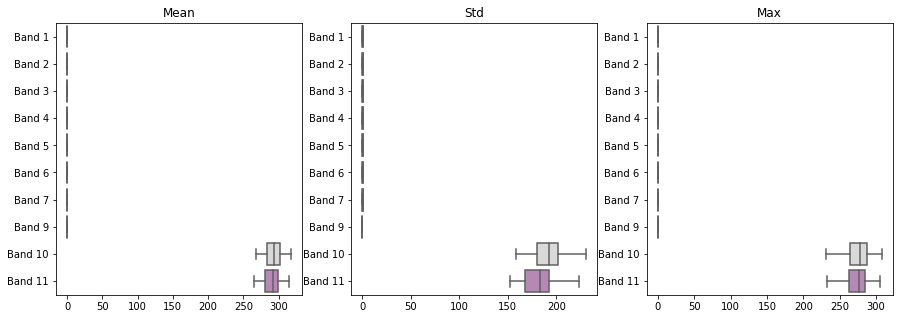

In [3]:
oli_scaling = 10000  # This number comes from the scaling factor in the TOA algorithm in the Python Fmask package

# Scaling for TIRS instrument (band 10 and 11) is from https://landsat.usgs.gov/using-usgs-landsat-8-product
RADIANCE_MULT_BAND_10 = 3.3420E-04  # Parameters from any of the Landsat 8 mtl files
RADIANCE_MULT_BAND_11 = 3.3420E-04
RADIANCE_ADD_BAND_10 = 0.10000
RADIANCE_ADD_BAND_11 = 0.10000
K1_CONSTANT_BAND_10 = 774.89  
K1_CONSTANT_BAND_11 = 480.89
K2_CONSTANT_BAND_10 = 1321.08
K2_CONSTANT_BAND_11 = 1201.14

df_sparcs_mean = pd.DataFrame({'Band 1':sparcs_band_mean_per_product[:,0]/oli_scaling,
                               'Band 2':sparcs_band_mean_per_product[:,1]/oli_scaling,
                               'Band 3':sparcs_band_mean_per_product[:,2]/oli_scaling,
                               'Band 4':sparcs_band_mean_per_product[:,3]/oli_scaling,
                               'Band 5':sparcs_band_mean_per_product[:,4]/oli_scaling,
                               'Band 6':sparcs_band_mean_per_product[:,5]/oli_scaling,
                               'Band 7':sparcs_band_mean_per_product[:,6]/oli_scaling,
                               'Band 9':sparcs_band_mean_per_product[:,7]/oli_scaling,
                               'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_mean_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                               'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_mean_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_sparcs_std = pd.DataFrame({'Band 1':sparcs_band_std_per_product[:,0]/oli_scaling,
                              'Band 2':sparcs_band_std_per_product[:,1]/oli_scaling,
                              'Band 3':sparcs_band_std_per_product[:,2]/oli_scaling,
                              'Band 4':sparcs_band_std_per_product[:,3]/oli_scaling,
                              'Band 5':sparcs_band_std_per_product[:,4]/oli_scaling,
                              'Band 6':sparcs_band_std_per_product[:,5]/oli_scaling,
                              'Band 7':sparcs_band_std_per_product[:,6]/oli_scaling,
                              'Band 9':sparcs_band_std_per_product[:,7]/oli_scaling,
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_std_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_std_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_sparcs_max = pd.DataFrame({'Band 1':sparcs_band_max_per_product[:,0]/oli_scaling,
                              'Band 2':sparcs_band_max_per_product[:,1]/oli_scaling,
                              'Band 3':sparcs_band_max_per_product[:,2]/oli_scaling,
                              'Band 4':sparcs_band_max_per_product[:,3]/oli_scaling,
                              'Band 5':sparcs_band_max_per_product[:,4]/oli_scaling,
                              'Band 6':sparcs_band_max_per_product[:,5]/oli_scaling,
                              'Band 7':sparcs_band_max_per_product[:,6]/oli_scaling,
                              'Band 9':sparcs_band_max_per_product[:,7]/oli_scaling,
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*sparcs_band_max_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*sparcs_band_max_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

# Plot 
plt.figure(figsize=(15, 5))
order = ["Band 1", "Band 2", "Band 3", "Band 4", "Band 5", "Band 6", "Band 7", 
         "Band 9", "Band 10", "Band 11"]

plt.subplot(1, 3, 1)
plt.title('Mean')
sns.boxplot(data=df_sparcs_mean, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 2)
plt.title('Std')
sns.boxplot(data=df_sparcs_std, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 3)
plt.title('Max')
sns.boxplot(data=df_sparcs_max, order=order, palette="Set3",  orient="h", showfliers=False)

plt.show()

In [4]:
df_sparcs_mask = pd.DataFrame({'Shadow':sparcs_pixels_per_class[:,0],
                               'Shadow over water':sparcs_pixels_per_class[:,1],
                               'Water':sparcs_pixels_per_class[:,2],
                               'Snow':sparcs_pixels_per_class[:,3],
                               'Land':sparcs_pixels_per_class[:,4],
                               'Cloud':sparcs_pixels_per_class[:,5],
                               'Flooded':sparcs_pixels_per_class[:,6]})

df_sparcs_mask.head(5)

,Cloud,Flooded,Land,Shadow,Shadow over water,Snow,Water
0,33438.0,0.0,929942.0,3648.0,0.0,0.0,32972.0
1,246495.0,0.0,639901.0,104920.0,2106.0,0.0,6578.0
2,44086.0,0.0,9993.0,58727.0,454.0,864422.0,22318.0
3,21382.0,0.0,932706.0,17769.0,66.0,0.0,28077.0
4,224482.0,0.0,332513.0,132038.0,7042.0,264448.0,39477.0


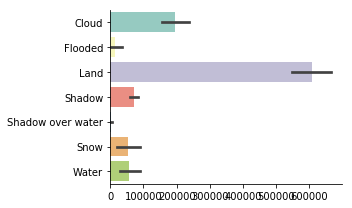

In [5]:
# Draw a count plot
plt.figure(figsize=(5, 3))
sns.barplot(data=df_sparcs_mask, palette="Set3",  orient="h")
sns.despine()
plt.tight_layout()
#plt.savefig("../reports/figures/dataset_statistics/sparcs_classes_countplot.pdf")
plt.show()

### Calculate for Biome dataset

In [6]:
folders = sorted(os.listdir("../data/raw/Biome_dataset/"))
folders = [f for f in folders if '.' not in f]  # Filter out .gitignore

biome_pixels_per_class = np.zeros((96, 5))  # 96 products with 5 classes
biome_band_mean_per_product = np.zeros((96, 10))  # 96 products with 10 bands (discard band 8)
biome_band_std_per_product = np.zeros((96, 10))  # 96 products with 10 bands
biome_band_max_per_product = np.zeros((96, 10))  # 96 products with 10 bands
# Have at least one pixel for each class to avoid issues with the colors in the figure
biome_classes = np.zeros((5))
biome_classes[0] = 0
biome_classes[1] = 64
biome_classes[2] = 128
biome_classes[3] = 192
biome_classes[4] = 255

i = 0

for folder in folders:
    products = sorted(os.listdir("../data/raw/Biome_dataset/" + folder + "/BC/"))
    print('Processing products with ' + folder + ' background')
    for product in products:
        raw_path = "../data/raw/Biome_dataset/" + folder + "/BC/" + product + "/"
        toa_path = "../data/processed/Biome_TOA/" + folder + "/BC/" + product + "/"
        mask = tiff.imread(raw_path + product + "_fixedmask.TIF")
        
        for j, c in enumerate(biome_classes):
            biome_pixels_per_class[i, j] = np.count_nonzero(mask == c)        
        
        # Band [1:7, 9]
        toa_file = tiff.imread(toa_path + product + "_toa.TIF")
        for j in range(0, 8):            
            img_band = toa_file[:, :, j]
            img_band = img_band[img_band != 32767]  # Discard fill pixels                  
            biome_band_mean_per_product[i, j] = np.mean(img_band)
            biome_band_std_per_product[i, j] = np.std(img_band)  
            biome_band_max_per_product[i, j] = np.percentile(img_band, 0.98)  # Discard uppermost 2 percent to ignore outliers
        
        # Thermal bands (10 and 11)
        for j in range(10, 12):
            img_band = tiff.imread(raw_path + product + "_B" + str(j) + ".TIF")
            img_band = img_band[img_band != 0]  # Discard fill pixels
            biome_band_mean_per_product[i, j-2] = np.mean(img_band)
            biome_band_std_per_product[i, j-2] = np.std(img_band)  
            biome_band_max_per_product[i, j-2] = np.percentile(img_band, 0.98)  # Discard uppermost 2 percent to ignore outliers
            
        i += 1
        

Processing products with Barren background
Processing products with Forest background
Processing products with GrassCrops background
Processing products with Shrubland background
Processing products with SnowIce background
Processing products with Urban background
Processing products with Water background
Processing products with Wetlands background


Mean values
Band 1       0.465474
Band 10    272.951184
Band 11    270.469265
Band 2       0.443505
Band 3       0.401396
Band 4       0.411267
Band 5       0.477699
Band 6       0.237135
Band 7       0.190602
Band 9       0.038000
dtype: float64
Std values
Band 1       0.137082
Band 10    193.592683
Band 11    184.647540
Band 2       0.141451
Band 3       0.138529
Band 4       0.148812
Band 5       0.152284
Band 6       0.099817
Band 7       0.082171
Band 9       0.029271
dtype: float64
Max values
Band 1       0.915000
Band 10    314.251075
Band 11    317.154555
Band 2       0.882100
Band 3       0.784900
Band 4       0.785300
Band 5       0.773200
Band 6       0.215200
Band 7       0.190900
Band 9       0.094200
dtype: float64


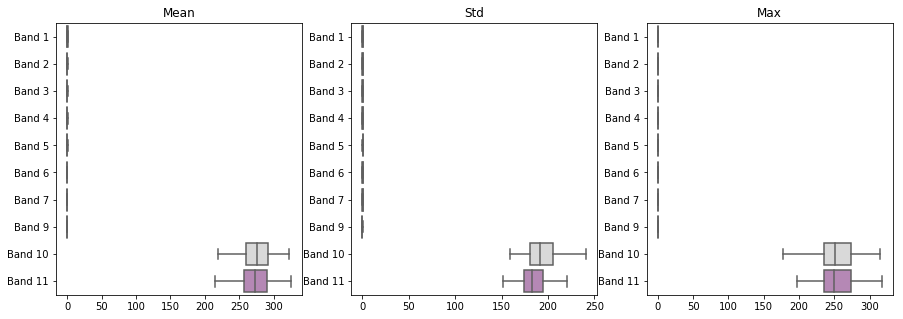

In [7]:
oli_scaling = 10000  # This number comes from the scaling factor in the TOA algorithm in the Python Fmask package

# Scaling for TIRS instrument (band 10 and 11) is from https://landsat.usgs.gov/using-usgs-landsat-8-product
RADIANCE_MULT_BAND_10 = 3.3420E-04  # Parameters from any of the Landsat 8 mtl files
RADIANCE_MULT_BAND_11 = 3.3420E-04
RADIANCE_ADD_BAND_10 = 0.10000
RADIANCE_ADD_BAND_11 = 0.10000
K1_CONSTANT_BAND_10 = 774.89  
K1_CONSTANT_BAND_11 = 480.89
K2_CONSTANT_BAND_10 = 1321.08
K2_CONSTANT_BAND_11 = 1201.14

df_biome_mean = pd.DataFrame({'Band 1':biome_band_mean_per_product[:,0]/oli_scaling,
                              'Band 2':biome_band_mean_per_product[:,1]/oli_scaling,
                              'Band 3':biome_band_mean_per_product[:,2]/oli_scaling,
                              'Band 4':biome_band_mean_per_product[:,3]/oli_scaling,
                              'Band 5':biome_band_mean_per_product[:,4]/oli_scaling,
                              'Band 6':biome_band_mean_per_product[:,5]/oli_scaling,
                              'Band 7':biome_band_mean_per_product[:,6]/oli_scaling,                              
                              'Band 9':biome_band_mean_per_product[:,7]/oli_scaling,
                              'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_mean_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                              'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_mean_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_biome_std = pd.DataFrame({'Band 1':biome_band_std_per_product[:,0]/oli_scaling,
                             'Band 2':biome_band_std_per_product[:,1]/oli_scaling,
                             'Band 3':biome_band_std_per_product[:,2]/oli_scaling,
                             'Band 4':biome_band_std_per_product[:,3]/oli_scaling,
                             'Band 5':biome_band_std_per_product[:,4]/oli_scaling,
                             'Band 6':biome_band_std_per_product[:,5]/oli_scaling,
                             'Band 7':biome_band_std_per_product[:,6]/oli_scaling,
                             'Band 9':biome_band_std_per_product[:,7]/oli_scaling,
                             'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_std_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                             'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_std_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

df_biome_max = pd.DataFrame({'Band 1':biome_band_max_per_product[:,0]/oli_scaling,
                             'Band 2':biome_band_max_per_product[:,1]/oli_scaling,
                             'Band 3':biome_band_max_per_product[:,2]/oli_scaling,
                             'Band 4':biome_band_max_per_product[:,3]/oli_scaling,
                             'Band 5':biome_band_max_per_product[:,4]/oli_scaling,
                             'Band 6':biome_band_max_per_product[:,5]/oli_scaling,
                             'Band 7':biome_band_max_per_product[:,6]/oli_scaling,
                             'Band 9':biome_band_max_per_product[:,7]/oli_scaling,
                             'Band 10':K2_CONSTANT_BAND_10/(np.log(K1_CONSTANT_BAND_10/(RADIANCE_MULT_BAND_10*biome_band_max_per_product[:,8] + RADIANCE_ADD_BAND_10) + 1)),
                             'Band 11':K2_CONSTANT_BAND_11/(np.log(K1_CONSTANT_BAND_11/(RADIANCE_MULT_BAND_11*biome_band_max_per_product[:,9] + RADIANCE_ADD_BAND_11) + 1))})

print('Mean values')
print(df_biome_mean.mean())

print('Std values')
print(df_biome_std.mean())

print('Max values')
print(df_biome_max.max())

# Plot 
plt.figure(figsize=(15, 5))
order = ["Band 1", "Band 2", "Band 3", "Band 4", "Band 5", "Band 6", "Band 7", 
         "Band 9", "Band 10", "Band 11"]

plt.subplot(1, 3, 1)
plt.title('Mean')
sns.boxplot(data=df_biome_mean, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 2)
plt.title('Std')
sns.boxplot(data=df_biome_std, order=order, palette="Set3",  orient="h", showfliers=False)

plt.subplot(1, 3, 3)
plt.title('Max')
sns.boxplot(data=df_biome_max, order=order, palette="Set3",  orient="h", showfliers=False)

plt.show()

In [8]:
df_biome_mask = pd.DataFrame({'Fill':biome_pixels_per_class[:,0],
                              'Cloud Shadow':biome_pixels_per_class[:,1],
                              'Clear':biome_pixels_per_class[:,2],
                              'Thin Cloud':biome_pixels_per_class[:,3],
                              'Cloud':biome_pixels_per_class[:,4]})

df_biome_mask.head(5)

,Clear,Cloud,Cloud Shadow,Fill,Thin Cloud
0,41864930.0,0.0,0.0,37808321.0,0.0
1,782290.0,35155934.0,0.0,33742419.0,5939148.0
2,41876511.0,0.0,0.0,40678660.0,0.0
3,32038717.0,4743926.0,0.0,17375002.0,4835216.0
4,9593588.0,20433262.0,0.0,21311253.0,11559058.0


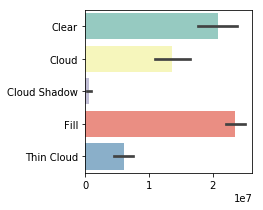

In [9]:
# Draw a count plot
plt.figure(figsize=(3, 3))
sns.barplot(data=df_biome_mask, palette="Set3",  orient="h")
plt.show()

### Create the figures

In [10]:
# Drop the 'Fill' column from the Biome dataset and normalize over the rest
df_biome_mask_normalized = df_biome_mask.drop('Fill', axis=1)
df_biome_mask_normalized = df_biome_mask_normalized.div(df_biome_mask_normalized.sum(axis=1), axis=0)

# Normalize the SPARCS dataset
df_sparcs_mask_normalized = df_sparcs_mask.div(df_sparcs_mask.sum(axis=1), axis=0)

# Merge the dataframes by having a new column named 'Dataset', and combine columns to fit eachother
df_merged_biome = pd.DataFrame({'Dataset': 'Biome',
                                'Clear':df_biome_mask_normalized['Clear'],
                                'Cloud':df_biome_mask_normalized['Cloud'] + df_biome_mask_normalized['Thin Cloud'], 
                                'Shadow': df_biome_mask_normalized['Cloud Shadow']})

df_merged_sparcs = pd.DataFrame({'Dataset': 'SPARCS',
                                 'Clear':df_sparcs_mask_normalized['Land'] + df_sparcs_mask_normalized['Water'] + df_sparcs_mask_normalized['Snow'] + df_sparcs_mask_normalized['Flooded'],
                                 'Cloud':df_sparcs_mask_normalized['Cloud'], 
                                 'Shadow': df_sparcs_mask_normalized['Shadow'] + df_sparcs_mask_normalized['Shadow over water']})

df_merged_mask = df_merged_biome.append(df_merged_sparcs, ignore_index=True)
df_merged_mask.tail(5)

,Clear,Cloud,Dataset,Shadow
171,0.544720,0.280457,SPARCS,0.174823
172,0.842828,0.087351,SPARCS,0.069821
173,0.747852,0.188479,SPARCS,0.063669
174,0.797642,0.150610,SPARCS,0.051748
175,0.859371,0.123755,SPARCS,0.016874


In [11]:
# Drop the 'Fill' column from the Biome dataset and normalize over the rest
df_biome_mask_normalized = df_biome_mask.drop('Fill', axis=1)
df_biome_mask_normalized = df_biome_mask_normalized.div(df_biome_mask_normalized.sum(axis=1), axis=0)

# Normalize the SPARCS dataset
df_sparcs_mask_normalized = df_sparcs_mask.div(df_sparcs_mask.sum(axis=1), axis=0)

# Merge the dataframes by having new columns named 'Dataset' and 'Class'
df_merged_biome_clear = pd.DataFrame({'Dataset': 'Biome',
                                      'Class': 'Clear',
                                      'Coverage': df_biome_mask_normalized['Clear']})
df_merged_biome_cloud = pd.DataFrame({'Dataset': 'Biome',
                                      'Class': 'Cloud',
                                      'Coverage': df_biome_mask_normalized['Cloud'] + df_biome_mask_normalized['Thin Cloud']})
df_merged_biome_shadow = pd.DataFrame({'Dataset': 'Biome',
                                       'Class': 'Shadow',
                                       'Coverage': df_biome_mask_normalized['Cloud Shadow']})

df_merged_sparcs_clear = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Class': 'Clear',
                                       'Coverage': df_sparcs_mask_normalized['Land'] + df_sparcs_mask_normalized['Water'] + df_sparcs_mask_normalized['Snow'] + df_sparcs_mask_normalized['Flooded']})
df_merged_sparcs_cloud = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Class': 'Cloud',
                                       'Coverage': df_sparcs_mask_normalized['Cloud']})
df_merged_sparcs_shadow = pd.DataFrame({'Dataset': 'SPARCS',
                                        'Class': 'Shadow',
                                        'Coverage': df_sparcs_mask_normalized['Shadow'] + df_sparcs_mask_normalized['Shadow over water']})

df_merged_mask = df_merged_biome_clear.append([df_merged_biome_cloud, 
                                               df_merged_biome_shadow, 
                                               df_merged_sparcs_clear, 
                                               df_merged_sparcs_cloud, 
                                               df_merged_sparcs_shadow], ignore_index=True)
df_merged_mask.head(5)

,Class,Coverage,Dataset
0,Clear,1.000000,Biome
1,Clear,0.018680,Biome
2,Clear,1.000000,Biome
3,Clear,0.769831,Biome
4,Clear,0.230693,Biome


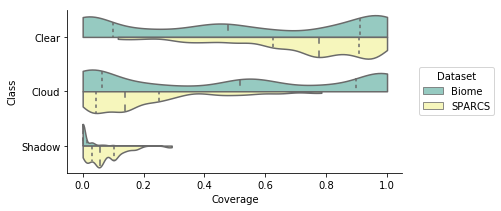

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)
#sns.set(font_scale=1.4) 

g = sns.factorplot(x="Coverage", y="Class",
                   hue="Dataset",
                   data=df_merged_mask,
                   orient="h", size=4, aspect=1, palette="Set3",
                   kind="violin", 
                   dodge=True, 
                   cut=0, 
                   bw=.2, 
                   split=True, 
                   legend=False, 
                   inner='quartile', 
                   scale='width',
                   ax=ax)
 
plt.close(g.fig)  # Seaborn created a new Figure which we don't want

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

leg = plt.legend(title='Dataset', bbox_to_anchor=(1.05, 0.65), loc=2, borderaxespad=0.)

plt.savefig("../reports/figures/dataset_statistics/Landsat8_class_distributions.pdf",  bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()

sns.reset_orig()  # Reset to org. font size

In [13]:
# Drop the 'Fill' column from the Biome dataset and normalize over the rest
df_biome_mask_normalized = df_biome_mask.drop('Fill', axis=1)
df_biome_mask_normalized = df_biome_mask_normalized.div(df_biome_mask_normalized.sum(axis=1), axis=0)

# Normalize the SPARCS dataset
df_sparcs_mask_normalized = df_sparcs_mask.div(df_sparcs_mask.sum(axis=1), axis=0)

# Merge the dataframes by having new columns named 'Dataset' and 'Class'
df_merged_bands = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 1,
                                      'Mean value': df_biome_mean['Band 1']})
df_merged_biome_band2 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 2,
                                      'Mean value': df_biome_mean['Band 2']})
df_merged_biome_band3 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 3,
                                      'Mean value': df_biome_mean['Band 3']})
df_merged_biome_band4 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 4,
                                      'Mean value': df_biome_mean['Band 4']})
df_merged_biome_band5 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 5,
                                      'Mean value': df_biome_mean['Band 5']})
df_merged_biome_band6 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 6,
                                      'Mean value': df_biome_mean['Band 6']})
df_merged_biome_band7 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 7,
                                      'Mean value': df_biome_mean['Band 7']})
df_merged_biome_band9 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 9,
                                      'Mean value': df_biome_mean['Band 9']})
df_merged_biome_band10 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 10,
                                      'Mean value': df_biome_mean['Band 10']})
df_merged_biome_band11 = pd.DataFrame({'Dataset': 'Biome',
                                      'Band': 11,
                                      'Mean value': df_biome_mean['Band 11']})

df_merged_sparcs_band1 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 1,
                                       'Mean value': df_sparcs_mean['Band 1']})
df_merged_sparcs_band2 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 2,
                                       'Mean value': df_sparcs_mean['Band 2']})
df_merged_sparcs_band3 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 3,
                                       'Mean value': df_sparcs_mean['Band 3']})
df_merged_sparcs_band4 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 4,
                                       'Mean value': df_sparcs_mean['Band 4']})
df_merged_sparcs_band5 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 5,
                                       'Mean value': df_sparcs_mean['Band 5']})
df_merged_sparcs_band6 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 6,
                                       'Mean value': df_sparcs_mean['Band 6']})
df_merged_sparcs_band7 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 7,
                                       'Mean value': df_sparcs_mean['Band 7']})
df_merged_sparcs_band9 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 9,
                                       'Mean value': df_sparcs_mean['Band 9']})
df_merged_sparcs_band10 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 10,
                                       'Mean value': df_sparcs_mean['Band 10']})
df_merged_sparcs_band11 = pd.DataFrame({'Dataset': 'SPARCS',
                                       'Band': 11,
                                       'Mean value': df_sparcs_mean['Band 11']})

df_merged_bands = df_merged_bands.append([df_merged_biome_band2,
                                          df_merged_biome_band3,
                                          df_merged_biome_band4,
                                          df_merged_biome_band5,
                                          df_merged_biome_band6,
                                          df_merged_biome_band7,
                                          df_merged_biome_band9,
                                          df_merged_biome_band10,
                                          df_merged_biome_band11, 
                                          df_merged_sparcs_band1, 
                                          df_merged_sparcs_band2, 
                                          df_merged_sparcs_band3,
                                          df_merged_sparcs_band4,
                                          df_merged_sparcs_band5,
                                          df_merged_sparcs_band6,
                                          df_merged_sparcs_band7,
                                          df_merged_sparcs_band9,
                                          df_merged_sparcs_band10,
                                          df_merged_sparcs_band11], ignore_index=True)
df_merged_bands.head(5)

,Band,Dataset,Mean value
0,1,Biome,0.222617
1,1,Biome,0.563046
2,1,Biome,0.727901
3,1,Biome,0.241937
4,1,Biome,0.404580


In [17]:
# Change style of s
sns.reset_orig()

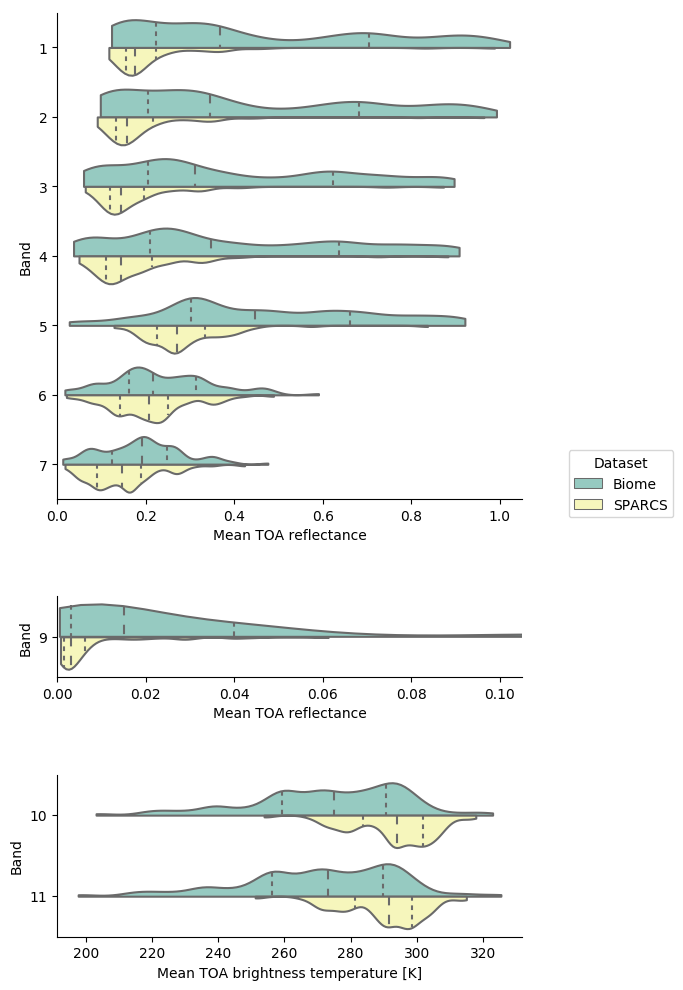

In [23]:
# Create a figure instance, and the two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(6,12), gridspec_kw = {'height_ratios':[6, 1, 2]})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=0.4)

# Plot the OLI bands
g1 = sns.factorplot(x="Mean value", y="Band",
                    hue="Dataset",
                    data=df_merged_bands.loc[df_merged_bands['Band'] < 9],
                    orient="h", size=6, aspect=0.8, palette="Set3",
                    kind="violin", 
                    dodge=True, 
                    cut=0, 
                    bw=.2, 
                    split=True, 
                    legend=True, 
                    inner='quartile', 
                    scale='width', 
                    ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Mean TOA reflectance')
ax1.set_xlim([-0.00, 1.05])

g2 = sns.factorplot(x="Mean value", y="Band",
                    hue="Dataset",
                    data=df_merged_bands.loc[df_merged_bands['Band'] == 9],
                    orient="h", size=6, aspect=0.8, palette="Set3",
                    kind="violin", 
                    dodge=True, 
                    cut=0, 
                    bw=.2, 
                    split=True, 
                    legend=False, 
                    inner='quartile', 
                    scale='width', 
                    ax=ax2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Mean TOA reflectance')
ax2.set_xlim([-0.00, 0.105])
ax2.legend().set_visible(False)

# Plot the TIRS bands
g3 = sns.factorplot(x="Mean value", y="Band",
                    hue="Dataset",
                    data=df_merged_bands.loc[df_merged_bands['Band'] > 9],
                    orient="h", size=3, aspect=2.5, palette="Set3",
                    kind="violin", 
                    dodge=False, 
                    cut=0.2, 
                    bw=.2, 
                    split=True, 
                    legend=False, 
                    inner='quartile', 
                    scale='width',
                    ax=ax3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.legend().set_visible(False)
ax3.set_xlabel('Mean TOA brightness temperature [K]')

# Close figures created by the factorplot function
plt.close(g1.fig)  # https://stackoverflow.com/questions/33925494/seaborn-produces-separate-figures-in-subplots
plt.close(g2.fig)
plt.close(g3.fig)

leg = ax1.legend(title='Dataset', bbox_to_anchor=(1.1, 0.1), loc=2, borderaxespad=0.)

#plt.legend(loc='lower right')
#plt.tight_layout()
plt.savefig("../reports/figures/dataset_statistics/Landsat8_band_distributions.pdf",  bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()